In [2]:
from pinecone import Pinecone, ServerlessSpec
import os
from dotenv import load_dotenv
from pathlib import Path
from PIL import Image
from langchain_openai import OpenAIEmbeddings

load_dotenv()

pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))




In [3]:
embedding_model = OpenAIEmbeddings(model="text-embedding-3-large")

In [4]:
index_name = "agusto-demo"

In [ ]:
index_name = "agusto-demo"

pc.create_index(
    name=index_name,
    dimension=3072, # Replace with your model dimensions
    metric="cosine", # Replace with your model metric
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    ) 
)

In [8]:
from markitdown import MarkItDown
from openai import OpenAI


In [9]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))


In [10]:
md_engine = MarkItDown(llm_model="gpt-4o", llm_client=client)


In [11]:
def extract_page_number(filename):
    # Use regex to find text between last '_' and '.png'
    import re
    try:
        match = re.search(r'_([^_]+)\.png$', filename)
        return 'page_' + match.group(1) if match else None
    except AttributeError:
        return None

In [12]:
extract_page_number('Republic of Rwanda - 2024 Sovereign Rating Rationale\Republic of Rwanda - 2024 Sovereign Rating Rationale_page_2.png')

'page_2'

In [13]:
index = pc.Index(index_name)

In [17]:
meta_data = []
embeddings = []

DOCUMENTS_DIR = Path('documents')

for folders in os.listdir(DOCUMENTS_DIR):
    folder_path = DOCUMENTS_DIR / folders
    if not folder_path.is_dir():
        continue
    for file in os.listdir(folder_path):
        if file.endswith(".png"):
            image_path = DOCUMENTS_DIR / folders / file
            page_number = extract_page_number(file)
            print(image_path)
            image_description = md_engine.convert(image_path)
            meta_data.append({
                "page_number": page_number,
                "image_description": image_description.text_content,
                "document_name": str(file),
                "document_path": str(image_path),
                "id": str(file).replace(".png", "")
            })

            embedded_data = embedding_model.embed_query(image_description.text_content)
            embeddings.append(embedded_data)
            
id = [id_key["id"] for id_key in meta_data]
index.upsert(vectors=zip(id, embeddings, meta_data))



documents/Motor Claims Handling Guidelines/Motor Claims Handling Guidelines_page_3.png
documents/Motor Claims Handling Guidelines/Motor Claims Handling Guidelines_page_2.png
documents/Motor Claims Handling Guidelines/Motor Claims Handling Guidelines_page_1.png
documents/Motor Takaful Policy/Motor Takaful Policy_page_1.png
documents/Motor Takaful Policy/Motor Takaful Policy_page_2.png


{'upserted_count': 5}

In [ ]:
print(len(meta_data))

16


In [ ]:
for i in range(len(meta_data)):
    print(meta_data[i])


{'page_number': 'page_1', 'image_description': '\n# Description:\nThe image features the cover page of the "2024 Sovereign Rating Report on the Republic of Rwanda" by Agusto & Co. The design prominently displays the Rwandan flag, encapsulated in a glossy, round emblem, symbolizing national pride. The top left corner includes the Agusto & Co. logo accompanied by the text: "Research, Credit Ratings, Credit Risk Management," highlighting the company\'s expertise. The background features a dynamic pattern of pink and orange geometric shapes, adding a modern and vibrant aesthetic to the cover. The title of the report is clearly presented in bold white lettering against a dark blue background in the lower section, ensuring clarity and impact. The overall design conveys professionalism and a focus on detailed financial analysis.\n', 'document_name': 'Republic of Rwanda - 2024 Sovereign Rating Rationale_page_1.png', 'document_path': 'documents\\Republic of Rwanda - 2024 Sovereign Rating Ration

In [ ]:
id = [id_key["id"] for id_key in meta_data]
print(id)


['Republic of Rwanda - 2024 Sovereign Rating Rationale_page_1', 'Republic of Rwanda - 2024 Sovereign Rating Rationale_page_2', 'Republic of Rwanda - 2024 Sovereign Rating Rationale_page_3', 'Republic of Rwanda - 2024 Sovereign Rating Rationale_page_4', 'Republic of Rwanda - 2024 Sovereign Rating Rationale_page_5', 'Republic of Rwanda - 2024 Sovereign Rating Rationale_page_6', 'Republic of Rwanda - 2024 Sovereign Rating Rationale_page_7', 'Republic of Rwanda - 2024 Sovereign Rating Rationale_page_8', 'Republic of Uganda- 2024 Sovereign Rating Rationale_page_1', 'Republic of Uganda- 2024 Sovereign Rating Rationale_page_2', 'Republic of Uganda- 2024 Sovereign Rating Rationale_page_3', 'Republic of Uganda- 2024 Sovereign Rating Rationale_page_4', 'Republic of Uganda- 2024 Sovereign Rating Rationale_page_5', 'Republic of Uganda- 2024 Sovereign Rating Rationale_page_6', 'Republic of Uganda- 2024 Sovereign Rating Rationale_page_7', 'Republic of Uganda- 2024 Sovereign Rating Rationale_page_8']

In [ ]:
index.upsert(vectors=zip(id, embeddings, meta_data))

{'upserted_count': 16}

In [ ]:
result = md_engine.convert('documents\Republic of Uganda- 2024 Sovereign Rating Rationale\Republic of Uganda- 2024 Sovereign Rating Rationale_page_4.png')


In [ ]:
print(result.text_content)


# Description:
The image is a page from Agusto & Co.'s 2024 Sovereign Rating Report on the Republic of Uganda. It discusses Uganda's economic outlook, focusing on currency stability, unemployment, and foreign investment. Over the past three years, Uganda's currency has shown minimal depreciation against the US dollar, with a 1.2% drop in 2023. The report notes a potential rise in aggregate demand for imports, possibly impacting exchange rates. Despite a competitive unemployment rate of 2.9% in 2023, an anticipated rise is expected due to skill mismatches and limited jobs. However, government efforts in industrial sectors, education, and infrastructure aim to boost employment. The report attaches a stable outlook to Uganda, with a bar graph showing real GDP growth rates from FY 2013/14 to FY 2024/25f, highlighting variations in economic growth over the years. The source is cited as Uganda Bureau of Statistics, Agusto & Co.



In [ ]:
def retreive_from_pinecone(query):
    embedded_query = embedding_model.embed_query(query)
    result = index.query(vector=embedded_query, top_k=3, include_metadata=True)
    matches = []
    
    for match in result['matches']:
        match_dict = {
            'document_name': match['metadata']['document_name'].replace('.png', '.pdf'),
            'document_path': match['metadata']['document_path'],
            'page_number': match['metadata']['page_number'],
            'page_description': match['metadata']['image_description'],
            'score': match['score'],
            'id': match['id']
        }
        matches.append(match_dict)
    
    return matches

In [ ]:
result = retreive_from_pinecone("What is the rating of the Republic of Uganda?")
print(result)

[{'document_name': 'Republic of Uganda- 2024 Sovereign Rating Rationale_page_2.pdf', 'document_path': 'documents\\Republic of Uganda- 2024 Sovereign Rating Rationale\\Republic of Uganda- 2024 Sovereign Rating Rationale_page_2.png', 'page_number': 'page_2', 'page_description': '\n# Description:\nThis image is a page from the "2024 Sovereign Rating Report on The Republic of Uganda" by Agusto & Co. It details the rationale behind assigning a "B" rating with a stable outlook to Uganda. Key points include:\n\n- Macroeconomic fundamentals: A real GDP growth rate of 4.5% over five years, projected to improve to 5.5% and 5.8% in FY 2023/24 and FY 2024/25, driven by the services and agriculture sectors.\n- Inflation: An average rate of 3.9% from 2019-2023, with stable debt to GDP and revenue ratios.\n- Government spending: Acceptable levels, with capital spending averaging 40% of government expenditure over the past five years.\n- Constraints: Political risks from opposition suppression, foreig

In [ ]:
print(result[0])

{'document_name': 'Republic of Uganda- 2024 Sovereign Rating Rationale_page_2.pdf', 'document_path': 'documents\\Republic of Uganda- 2024 Sovereign Rating Rationale\\Republic of Uganda- 2024 Sovereign Rating Rationale_page_2.png', 'page_number': 'page_2', 'page_description': '\n# Description:\nThis image is a page from the "2024 Sovereign Rating Report on The Republic of Uganda" by Agusto & Co. It details the rationale behind assigning a "B" rating with a stable outlook to Uganda. Key points include:\n\n- Macroeconomic fundamentals: A real GDP growth rate of 4.5% over five years, projected to improve to 5.5% and 5.8% in FY 2023/24 and FY 2024/25, driven by the services and agriculture sectors.\n- Inflation: An average rate of 3.9% from 2019-2023, with stable debt to GDP and revenue ratios.\n- Government spending: Acceptable levels, with capital spending averaging 40% of government expenditure over the past five years.\n- Constraints: Political risks from opposition suppression, foreign

In [ ]:
class PineconeRetriever:
    def __init__(self, index, embedding_model):
        """
        Initialize the PineconeRetriever with a Pinecone index and embedding model.
        
        Args:
            index: Pinecone index object
            embedding_model: Model to create embeddings for queries
        """
        self.index = index
        self.embedding_model = embedding_model
    
    def retrieve(self, query, top_k=3):
        """
        Retrieve documents from Pinecone based on a query.
        
        Args:
            query: The search query
            top_k: Number of results to return (default: 3)
            
        Returns:
            Pinecone query results
        """
        embedded_query = self.embedding_model.embed_query(query)
        result = self.index.query(vector=embedded_query, top_k=top_k, include_metadata=True)
        return result
    
    def display_image(self, match):
        """
        Display the image for a given match.
        
        Args:
            match: A match from Pinecone query results
        """
        try:
            image_path = Path(match['metadata']['document_path'])
            if image_path.exists():
                img = Image.open(image_path)
                display(img)
            else:
                print(f"Image not found at path: {image_path}")
        except Exception as e:
            print(f"Error displaying image: {e}")
    
    def display_description(self, match):
        """
        Display the description for a given match.
        
        Args:
            match: A match from Pinecone query results
        """
        try:
            description = match['metadata']['image_description']
            print("Document Description:")
            print(description)
            return description
        except Exception as e:
            print(f"Error displaying description: {e}")
    
    def display_document_info(self, match):
        """
        Display document name and page number for a given match.
        
        Args:
            match: A match from Pinecone query results
        """
        try:
            doc_name = match['metadata']['document_name']
            page_number = match['metadata']['page_number']
            print(f"Document: {doc_name}")
            print(f"Page: {page_number}")
            return page_number, doc_name
        except Exception as e:
            print(f"Error displaying document info: {e}")
    
    def display_full_result(self, match):
        """
        Display all information for a given match.
        
        Args:
            match: A match from Pinecone query results
        """
        print("-" * 50)
        self.display_document_info(match)
        print("-" * 50)
        self.display_description(match)
        print("-" * 50)
        self.display_image(match)
        print("-" * 50)

--------------------------------------------------
Document: Republic of Uganda- 2024 Sovereign Rating Rationale_page_2.png
Page: page_2
--------------------------------------------------
Document Description:

# Description:
This image is a page from the "2024 Sovereign Rating Report on The Republic of Uganda" by Agusto & Co. It details the rationale behind assigning a "B" rating with a stable outlook to Uganda. Key points include:

- Macroeconomic fundamentals: A real GDP growth rate of 4.5% over five years, projected to improve to 5.5% and 5.8% in FY 2023/24 and FY 2024/25, driven by the services and agriculture sectors.
- Inflation: An average rate of 3.9% from 2019-2023, with stable debt to GDP and revenue ratios.
- Government spending: Acceptable levels, with capital spending averaging 40% of government expenditure over the past five years.
- Constraints: Political risks from opposition suppression, foreign aid reliance, and weakening foreign reserves, at US$ 3.5 billion (3.2 mon

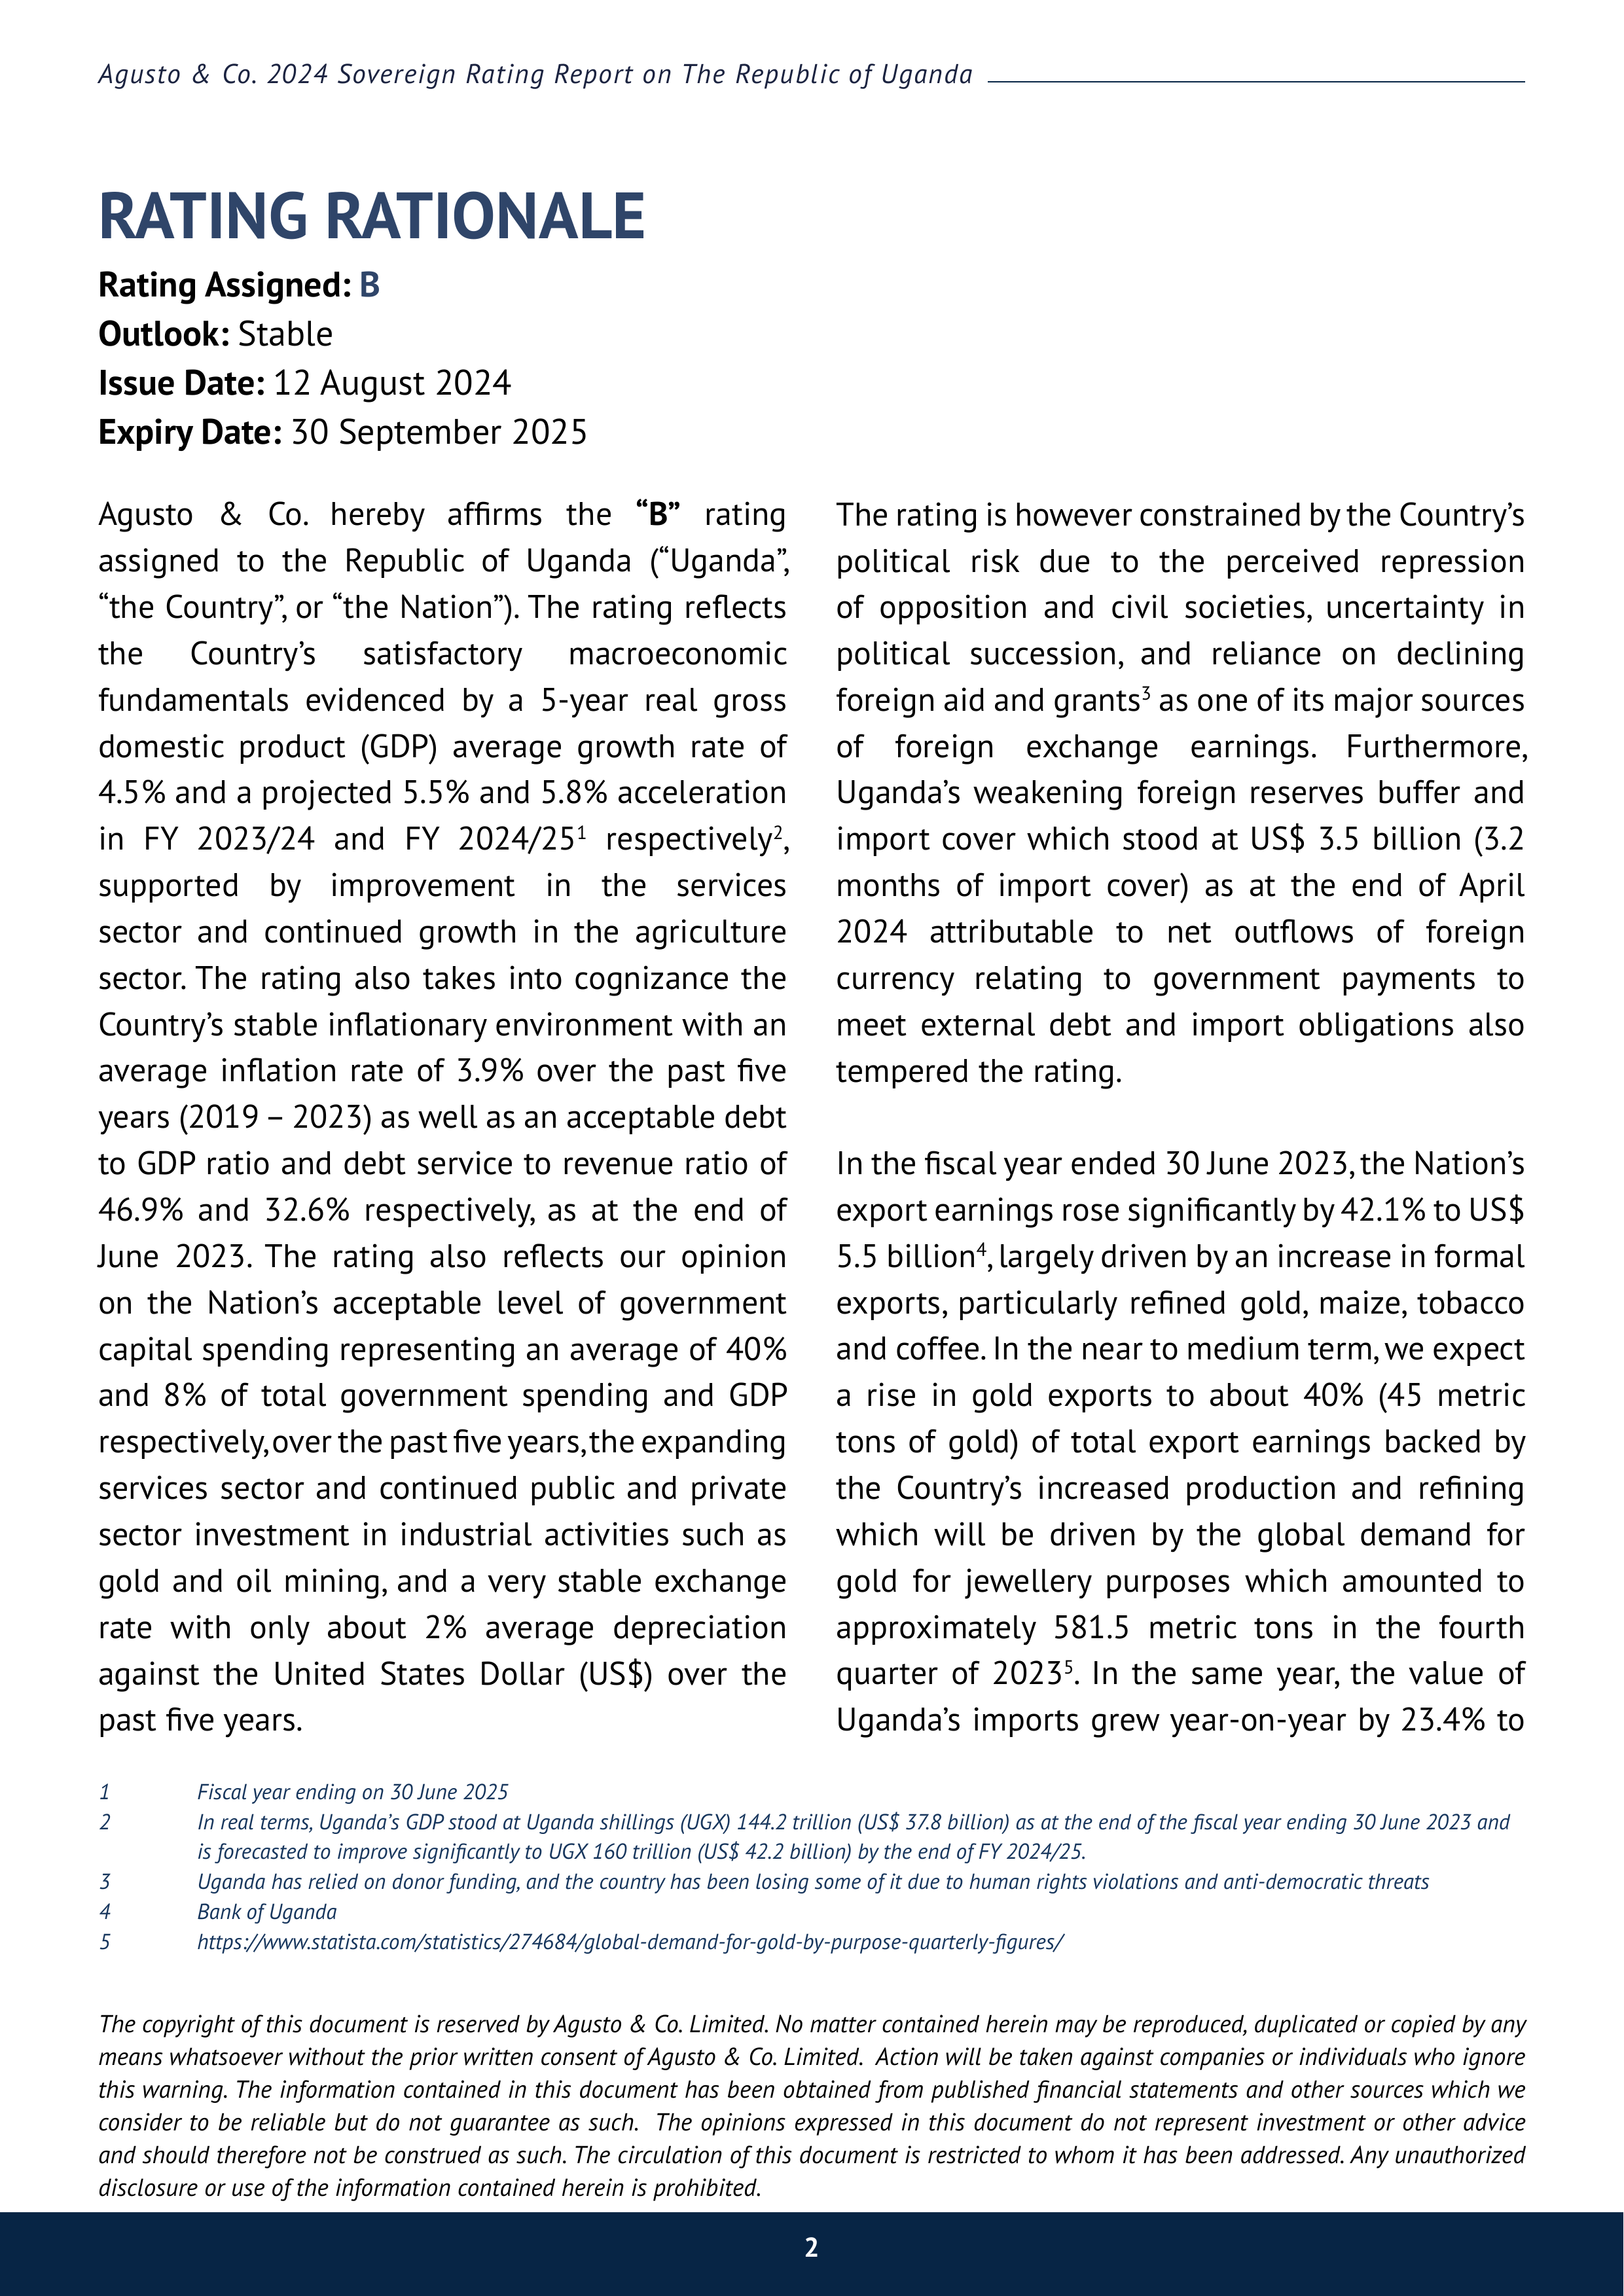

--------------------------------------------------
--------------------------------------------------
Document: Republic of Uganda- 2024 Sovereign Rating Rationale_page_4.png
Page: page_4
--------------------------------------------------
Document Description:

# Description:
This image is a page from the "Agusto & Co. 2024 Sovereign Rating Report on The Republic of Uganda." It discusses Uganda’s economic performance and outlook. Key points include:

- **Exchange Rate Stability**: From 2021 to 2023, Uganda's exchange rate to the US dollar remained stable with a minor depreciation rate, averaging 3,725 UGX to 1 USD in 2023.
- **GDP Growth**: The chart illustrates Uganda's real GDP growth rates from FY 2013/14 to FY 2024/25, showing fluctuations with a significant dip during 2020/21 but a projected growth of 5.8% in 2024/25.
- **Unemployment**: The unemployment rate was 2.9% in 2023, favorable compared to other African countries. Future moderate rises in unemployment are expected due to 

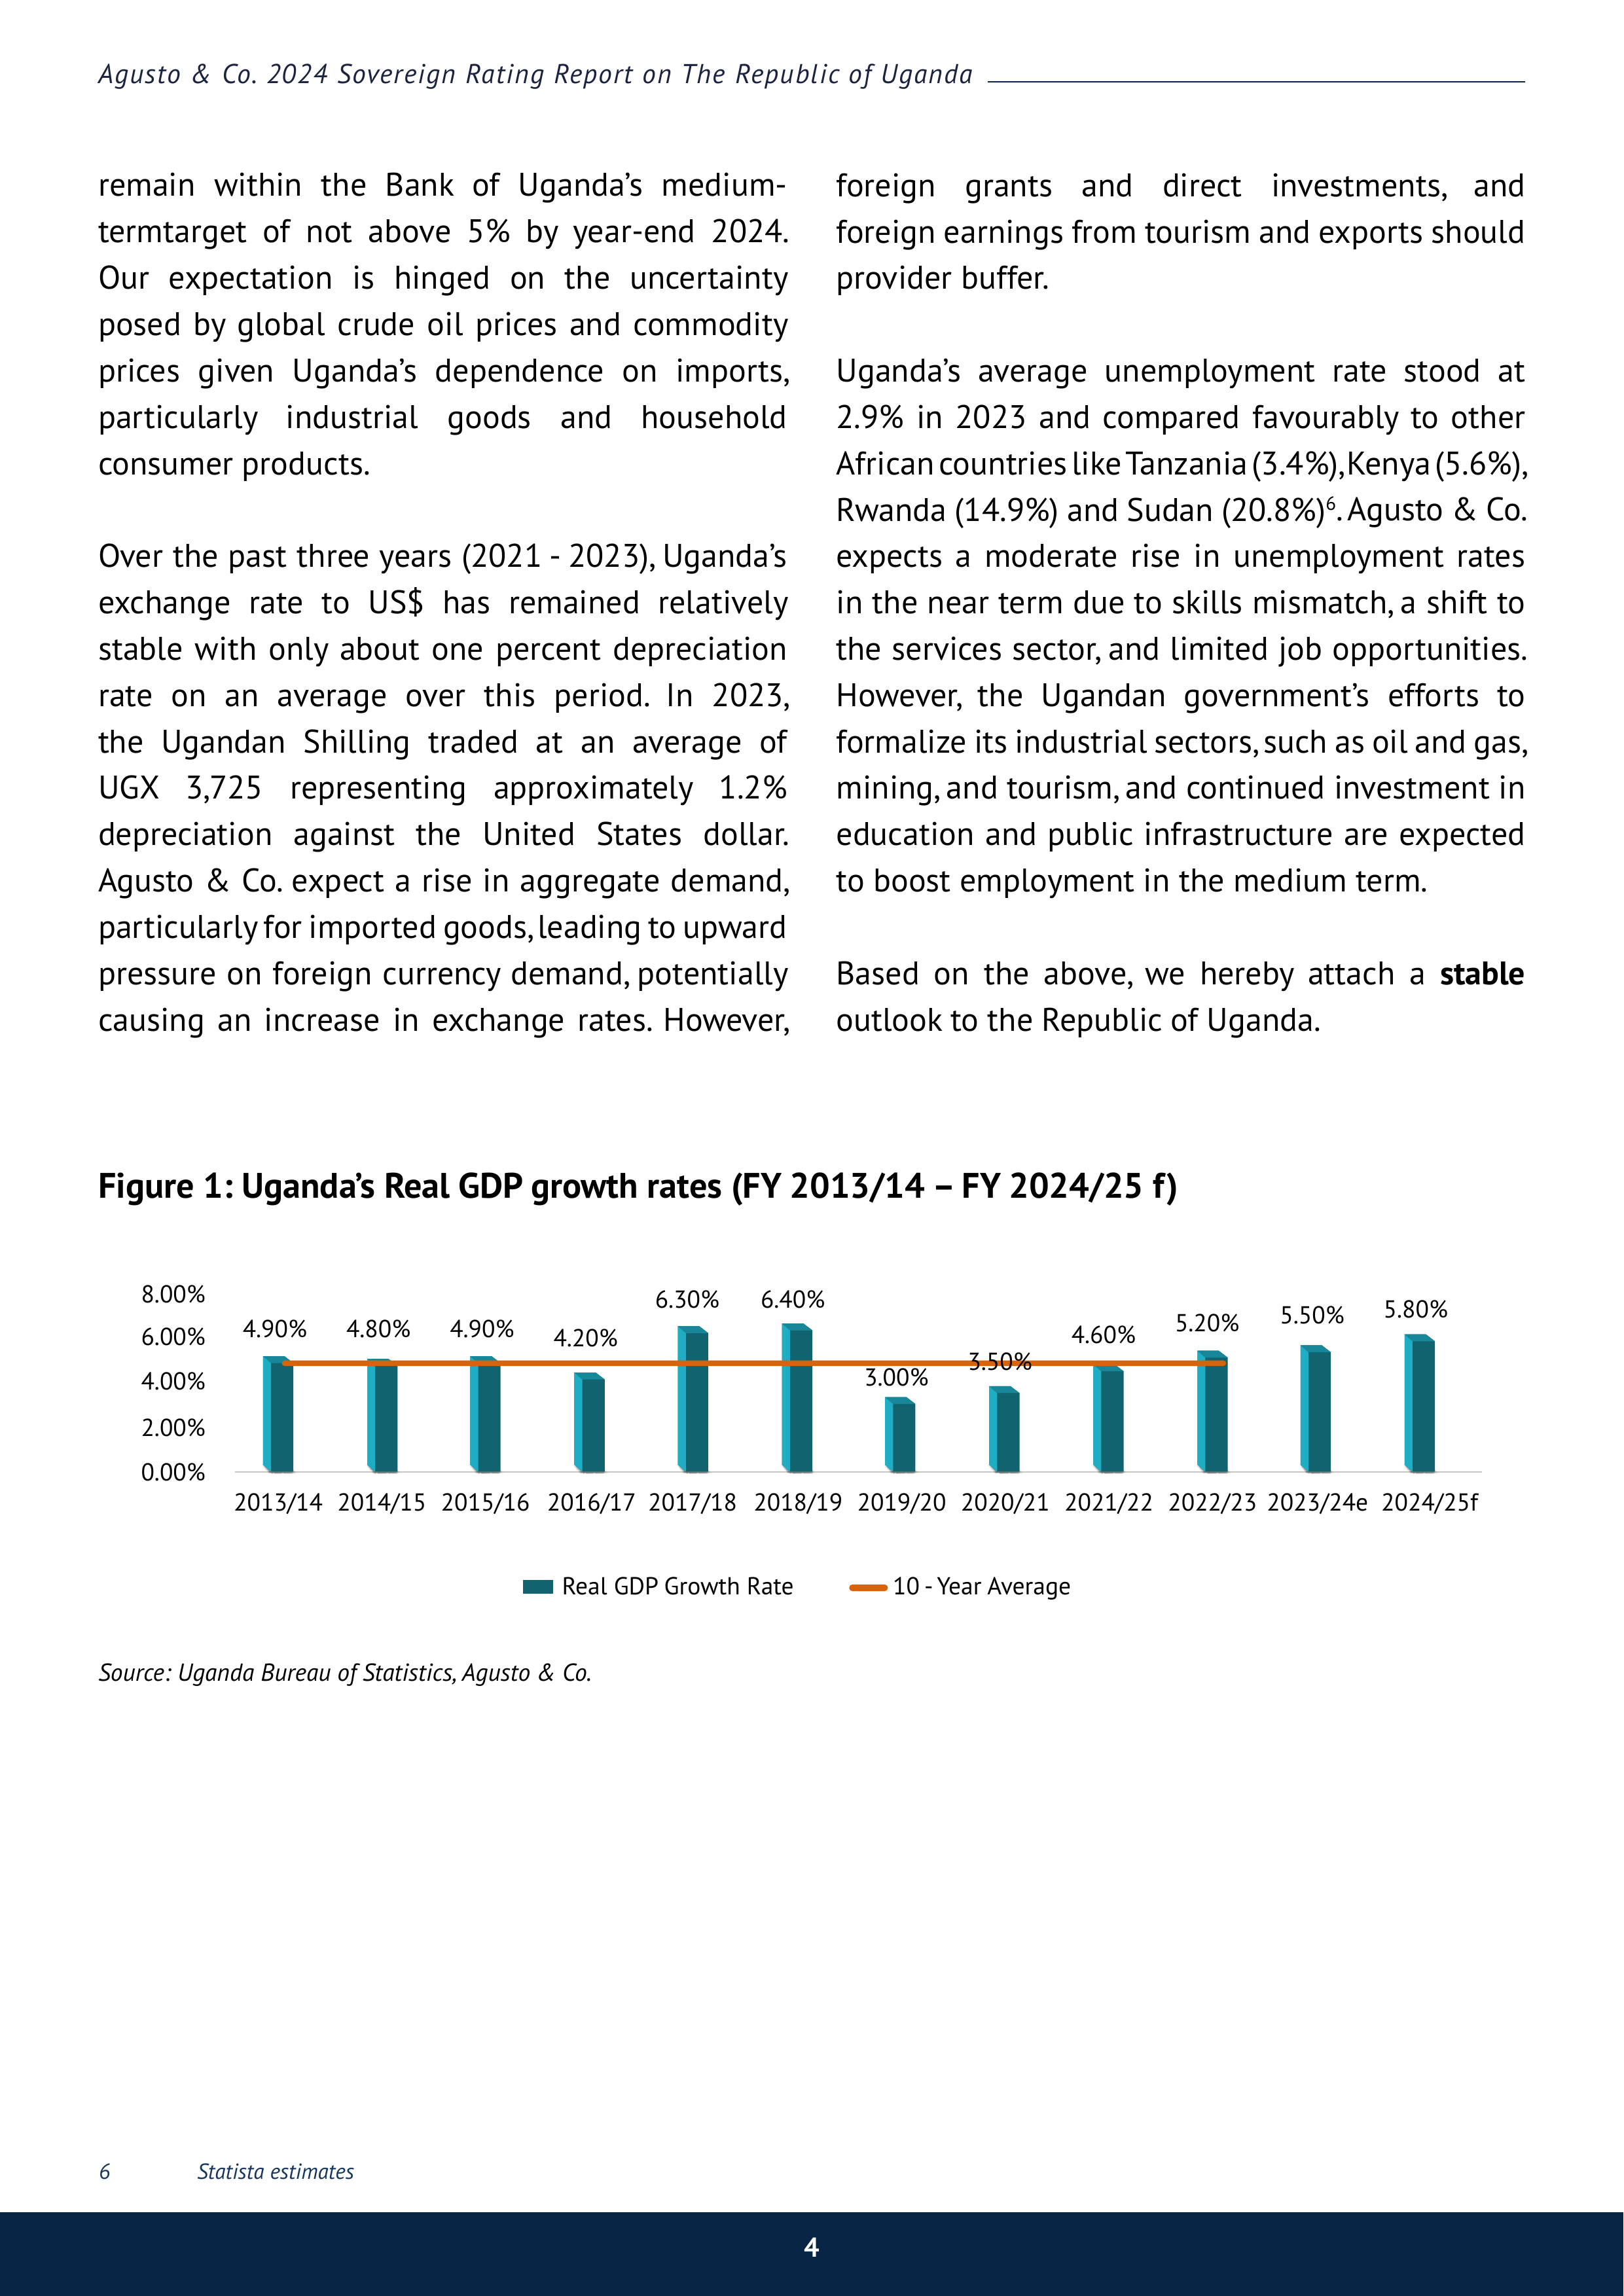

--------------------------------------------------
--------------------------------------------------
Document: Republic of Uganda- 2024 Sovereign Rating Rationale_page_1.png
Page: page_1
--------------------------------------------------
Document Description:

# Description:
This image displays the cover of a “Sovereign Rating Report on the Republic of Uganda” by Agusto & Co. Featured prominently is a stylized presentation of the Ugandan flag, with its distinctive black, yellow, and red horizontal stripes and the central crest showcasing the Grey Crowned Crane. The flag appears dynamically curved, suggesting vitality and movement. The Agusto & Co. logo is visible at the top left, underlining the company's expertise in research, credit ratings, and credit risk management. The design incorporates geometric shapes and subtle patterns to create a modern and professional aesthetic.

--------------------------------------------------


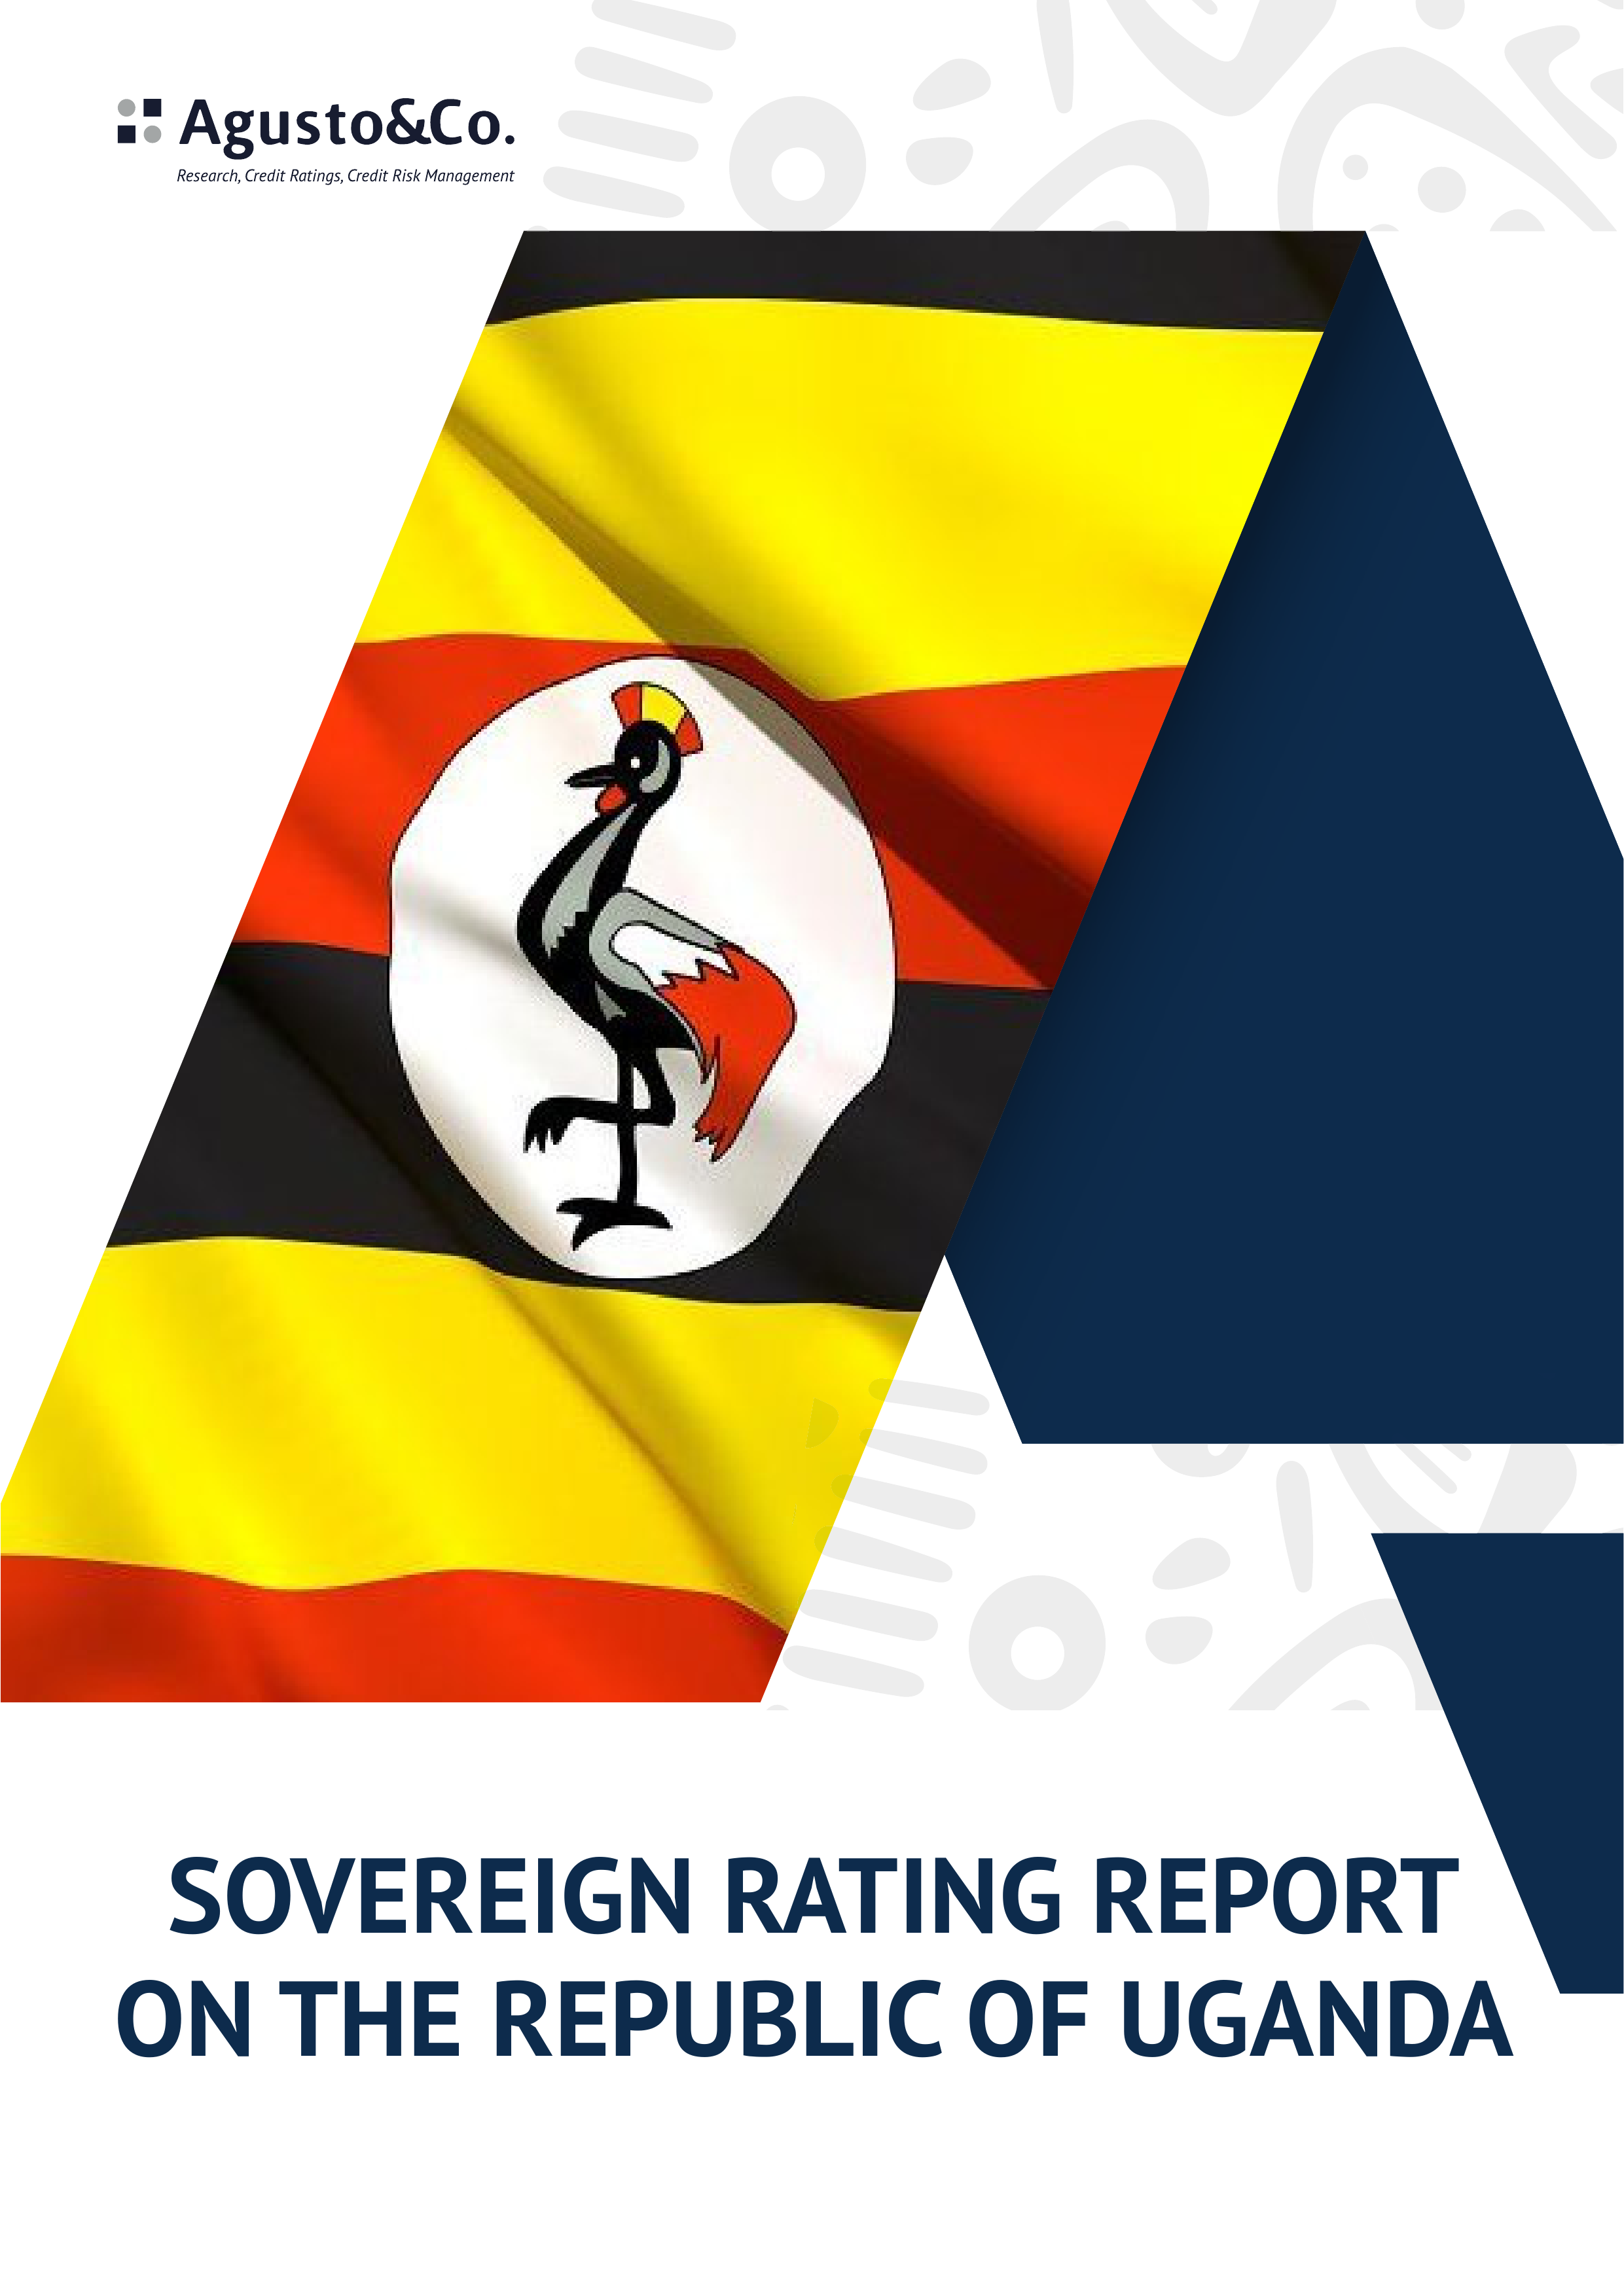

--------------------------------------------------


In [ ]:
# Create the retriever
retriever = PineconeRetriever(index, embedding_model)

# Search for documents
results = retriever.retrieve("What is the rating of the Republic of Uganda")

# Display information for each match
for match in results['matches']:
    retriever.display_full_result(match)
    
# Or access specific information
# retriever.display_image(results['matches'][0])
# retriever.display_description(results['matches'][0])
# retriever.display_document_info(results['matches'][0])

In [ ]:
print(results)

{'matches': [{'id': 'Fate_Foundation_MSME_Report_Final_page_8',
              'metadata': {'document_name': 'Fate_Foundation_MSME_Report_Final_page_8.png',
                           'document_path': 'documents\\Fate_Foundation_MSME_Report_Final\\Fate_Foundation_MSME_Report_Final_page_8.png',
                           'id': 'Fate_Foundation_MSME_Report_Final_page_8',
                           'image_description': '\n'
                                                '# Description:\n'
                                                'This image depicts a page '
                                                'from a report by FATE '
                                                'Foundation and Agusto & Co., '
                                                'detailing their efforts in '
                                                'supporting SMEs in Nigeria. '
                                                'The document introduces FATE '
                                          